In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from dmrgwaytorho import *
import qutip as q
from scipy import integrate,special
from scipy.linalg import eig,eigh,eigvals,eigvalsh
from scipy.sparse.linalg import eigs
import pickle 
from functions import doApplyHam,isingmodel,diagonalize,diagonalize_2
from functions import isingmodel_rev,isingmodel_rev_frac2,construct_ham




In [2]:
length=12
h=0.0000
lambdarange=np.linspace(0.1,2,100)

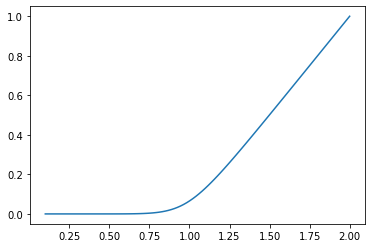

In [3]:
energies_dic={}
for l in lambdarange:

    Energies,psis=diagonalize(2,length,isingmodel_rev_frac2(l,h),True)

    energies_dic[l]=Energies
    
diffvec=[energies_dic[x][1] -energies_dic[x][0]  for x in energies_dic]
plt.plot(lambdarange,diffvec)      

In [4]:
length=12
h=0.0001
lambdarange=np.linspace(0.1,2,100)

In [5]:
dictionary_open0_h1={}
for L in (2,3,4):

    for l in lambdarange:

        Energies,psis=diagonalize(1,length,isingmodel_rev_frac2(l,h),True)

        reshapedpsi0=psis[:,0].reshape(2**int((length-L)/2),2**L,-1).transpose(1,0,2).reshape(2**L,-1)

        rhomagn0 = np.dot(reshapedpsi0, reshapedpsi0.conjugate().transpose())
        
        qrhomagn0=q.Qobj(rhomagn0,dims=[[2]*L,[2]*L])

        dictionary_open0_h1[l,L]=qrhomagn0

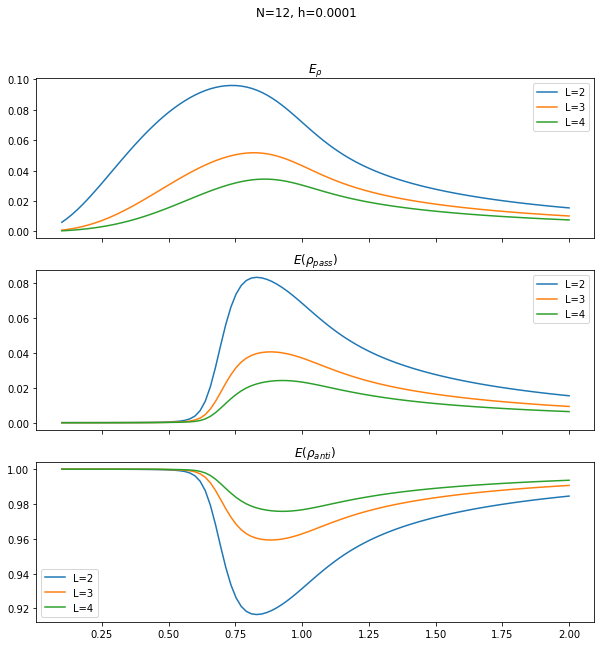

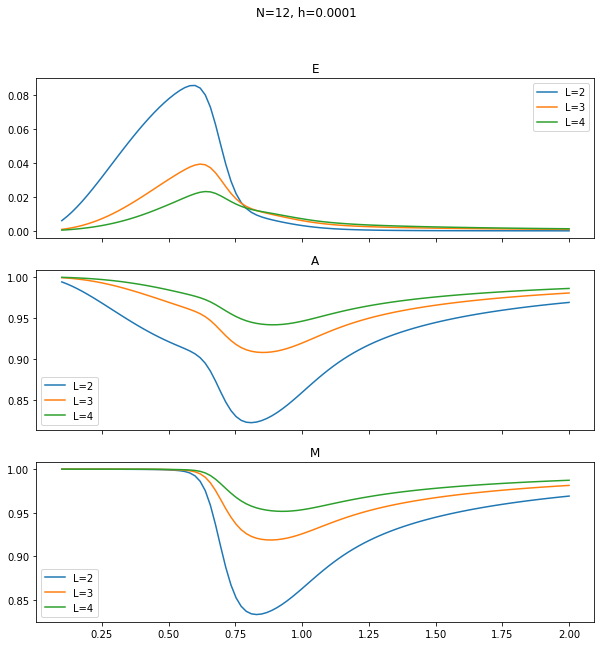

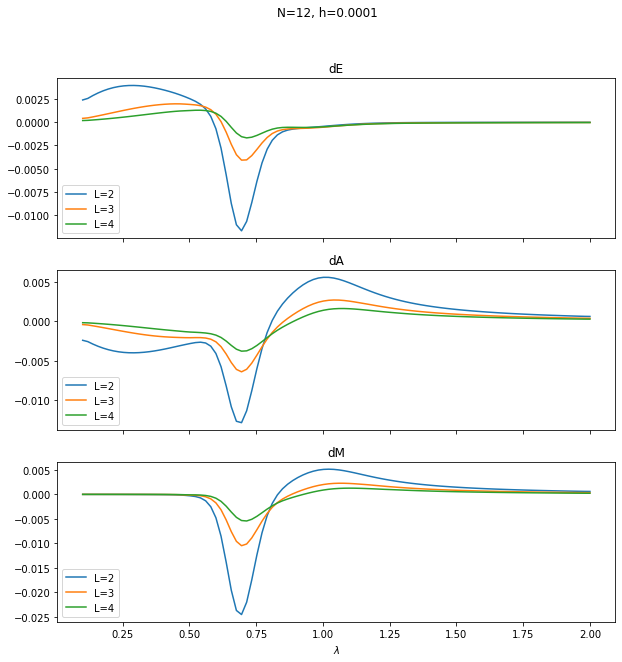

In [6]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
fig, axs = plt.subplots(3,sharex=True,figsize=[10,10])
fig2, axs2 = plt.subplots(3,sharex=True,figsize=[10,10])
fig3, axs3 = plt.subplots(3,sharex=True,figsize=[10,10])

for L in (2,3,4):

    energies_pass=np.zeros_like(lambdarange)
    energies_subs=np.zeros_like(lambdarange)
    energies_antipass=np.zeros_like(lambdarange)

    for j,l in enumerate(lambdarange):    

        qrho2=dictionary_open0_h1[l,L]

        eigval,eigstat=qrho2.eigenstates()

        reduced_H_matr=construct_ham(L,l)

        h_eigval, h_eigvec= reduced_H_matr.eigenstates()

        rho_pass=q.Qobj()
        rho_anti=q.Qobj()

        sortdesc=np.sort(eigval)[::-1]

        for i in range(len(eigval)):    
            rho_pass+=sortdesc[i]*q.ket2dm(h_eigvec[i])

        for i in range(len(eigval)):    
            rho_anti+=eigval[i]*q.ket2dm(h_eigvec[i])

        ener_pass=q.expect(rho_pass,reduced_H_matr)-h_eigval[0]
        ener_subs=q.expect(qrho2,reduced_H_matr)-h_eigval[0]
        ener_anti=q.expect(rho_anti,reduced_H_matr)-h_eigval[0]

        energies_pass[j]=(ener_pass)/(2*abs(h_eigval[0]))
        energies_subs[j]=(ener_subs)/(2*abs(h_eigval[0]))
        energies_antipass[j]=(ener_anti)/(2*abs(h_eigval[0]))


    fig.suptitle( 'N={}, h={}'.format(length,h))   

    axs[0].plot(lambdarange,energies_subs,label= "L={}".format(L))
    axs[0].set_title(r"$E_{\rho}$")
    axs[1].plot(lambdarange,energies_pass,label= "L={}".format(L))
    axs[1].set_title(r"$E(\rho_{pass})$")
    axs[2].plot(lambdarange,energies_antipass,label="L={}".format(L))
    axs[2].set_title(r"$E(\rho_{anti})$")

    for k in range(3):
        axs[k].legend()
    plt.xlabel(r"$\lambda$")
    
    fig.savefig("h1_rhos")
    fig2.suptitle("N={}, h={}".format(length,h))   

    axs2[0].plot(lambdarange,(energies_subs-energies_pass),label="L={}".format(L))        
    axs2[0].set_title("E")
    axs2[1].plot(lambdarange,(energies_antipass-energies_subs),label="L={}".format(L))
    axs2[1].set_title("A")    
    axs2[2].plot(lambdarange,(energies_antipass-energies_pass),label="L={}".format(L))
    axs2[2].set_title("M")

    for k in range(3):
        axs2[k].legend()
    plt.xlabel(r"$\lambda$")
    
    fig2.savefig("h1_ergos")
    fig3.suptitle("N={}, h={}".format(length,h)) 
    
    axs3[0].plot(lambdarange,np.gradient(energies_subs-energies_pass),label= "L={}".format(L))
    axs3[0].set_title(r"dE")
    axs3[1].plot(lambdarange,np.gradient(energies_antipass-energies_subs),label="L={}".format(L))
    axs3[1].set_title(r"dA")
    axs3[2].plot(lambdarange,np.gradient(energies_antipass-energies_pass),label="L={}".format(L))
    axs3[2].set_title("dM")    
    fig3.savefig("h1_dergos")

    for k in range(3):
        axs3[k].legend()
plt.show()   

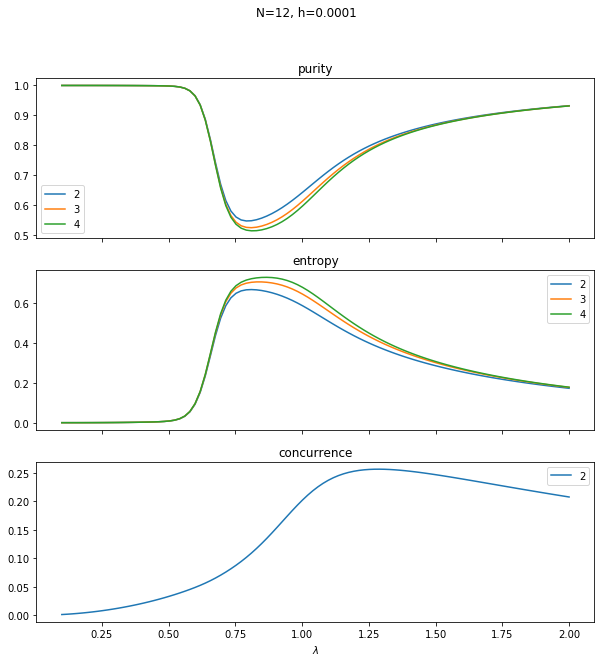

In [7]:
fig, axs = plt.subplots(3,sharex=True,figsize=[10,10])

for L in (2,3,4):

    purs=[]

    for j,l in enumerate(lambdarange):    

        qrho_2=dictionary_open0_h1[l,L]

        eigval,eigstat=qrho_2.eigenstates()

        eigsquared=[x**2 for x in eigval]

        purs.append(sum(eigsquared))

    axs[0].plot(lambdarange,purs,label=L)
    axs[0].set_title("purity")

    axs[0].legend()

    entros=[]

    for j,l in enumerate(lambdarange):    

        qrho_2=dictionary_open0_h1[l,L]

        entr=q.entropy_vn(qrho_2)

        entros.append(entr)

    axs[1].plot(lambdarange,entros,label=L)
    axs[1].legend()
    axs[1].set_title("entropy")
    if L==2:
        concs=[]

        for j,l in enumerate(lambdarange):    

            qrho_2=dictionary_open0_h1[l,2]

            conc=q.concurrence(qrho_2)

            concs.append(conc)

        axs[2].plot(lambdarange,concs,label=2)
        plt.xlabel(r"$\lambda$")
        axs[2].set_title("concurrence")

        axs[2].legend()
        fig.suptitle( 'N={}, h={}'.format(length,h))   
    plt.savefig("h1_quantities")
plt.show()

In [8]:
length=12
h_0=0.00
lambdarange=np.linspace(0.1,2,100)

In [9]:
dictionary_open0_h0={}
for L in (2,3,4):

    for l in lambdarange:

        
        Energies,psis=diagonalize(2,length,isingmodel_rev_frac2(l,h_0),True)

        reshapedpsi0=psis[:,0].reshape(2**int((length-L)/2),2**L,-1).transpose(1,0,2).reshape(2**L,-1)

        rhomagn0 = np.dot(reshapedpsi0, reshapedpsi0.conjugate().transpose())
        
        qrhomagn0=q.Qobj(rhomagn0,dims=[[2]*L,[2]*L])

        dictionary_open0_h0[l,L]=qrhomagn0
        


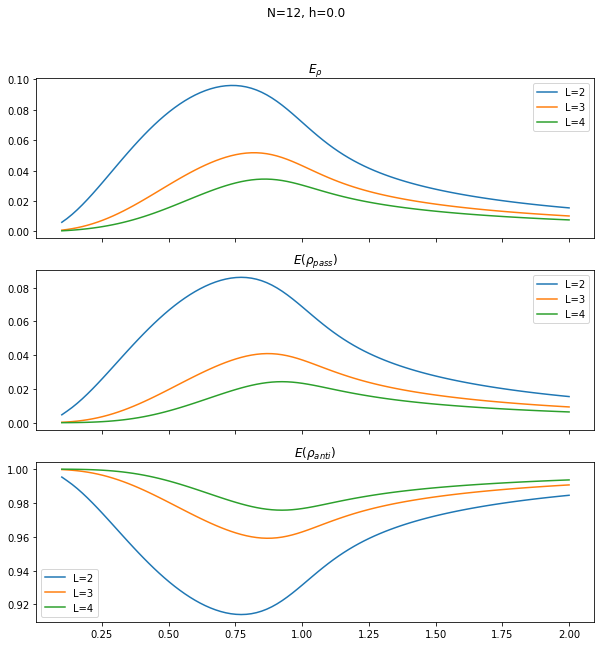

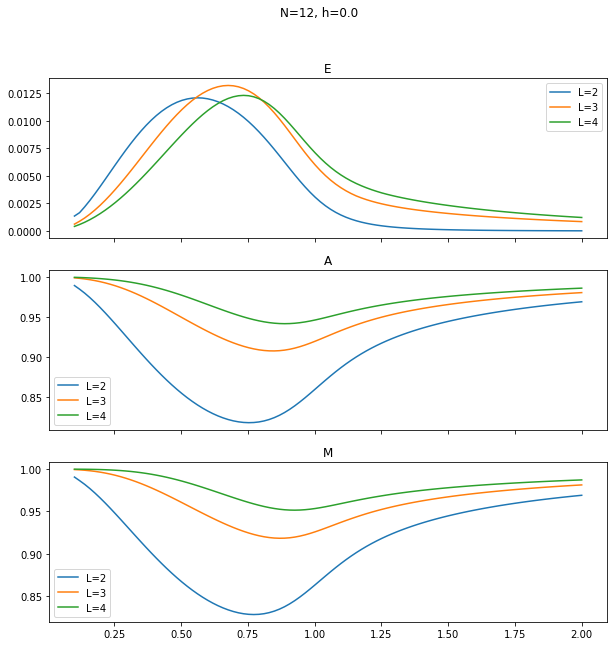

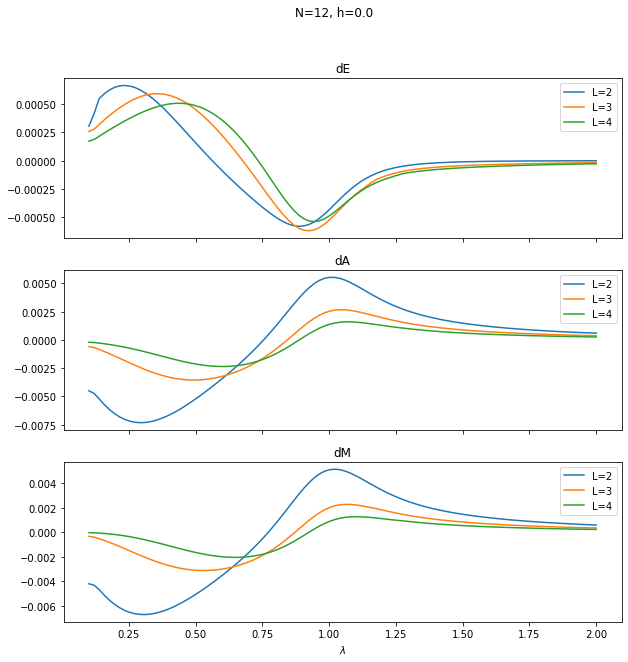

In [10]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
fig, axs = plt.subplots(3,sharex=True,figsize=[10,10])
fig2, axs2 = plt.subplots(3,sharex=True,figsize=[10,10])
fig3, axs3 = plt.subplots(3,sharex=True,figsize=[10,10])


for L in (2,3,4):

    energies_pass=np.zeros_like(lambdarange)
    energies_subs=np.zeros_like(lambdarange)
    energies_antipass=np.zeros_like(lambdarange)

    for j,l in enumerate(lambdarange):    

        qrho2=dictionary_open0_h0[l,L]

        eigval,eigstat=qrho2.eigenstates()

        reduced_H_matr=construct_ham(L,l)

        h_eigval, h_eigvec= reduced_H_matr.eigenstates()

        rho_pass=q.Qobj()
        rho_anti=q.Qobj()

        sortdesc=np.sort(eigval)[::-1]

        for i in range(len(eigval)):    
            rho_pass+=sortdesc[i]*q.ket2dm(h_eigvec[i])

        for i in range(len(eigval)):    
            rho_anti+=eigval[i]*q.ket2dm(h_eigvec[i])

        ener_pass=q.expect(rho_pass,reduced_H_matr)-h_eigval[0]
        ener_subs=q.expect(qrho2,reduced_H_matr)-h_eigval[0]
        ener_anti=q.expect(rho_anti,reduced_H_matr)-h_eigval[0]

        energies_pass[j]=(ener_pass)/(2*abs(h_eigval[0]))
        energies_subs[j]=(ener_subs)/(2*abs(h_eigval[0]))
        energies_antipass[j]=(ener_anti)/(2*abs(h_eigval[0]))


    fig.suptitle( 'N={}, h={}'.format(length,h_0))   

    axs[0].plot(lambdarange,energies_subs,label= "L={}".format(L))
    axs[0].set_title(r"$E_{\rho}$")
    axs[1].plot(lambdarange,energies_pass,label= "L={}".format(L))
    axs[1].set_title(r"$E(\rho_{pass})$")
    axs[2].plot(lambdarange,energies_antipass,label="L={}".format(L))
    axs[2].set_title(r"$E(\rho_{anti})$")

    for k in range(3):
        axs[k].legend()
    plt.xlabel(r"$\lambda$")
    
    fig.savefig("h0_rhos")
    fig2.suptitle("N={}, h={}".format(length,h_0))   

    axs2[0].plot(lambdarange,(energies_subs-energies_pass),label="L={}".format(L))        
    axs2[0].set_title("E")
    axs2[1].plot(lambdarange,(energies_antipass-energies_subs),label="L={}".format(L))
    axs2[1].set_title("A")    
    axs2[2].plot(lambdarange,(energies_antipass-energies_pass),label="L={}".format(L))
    axs2[2].set_title("M")
    
    for k in range(3):
        axs2[k].legend()
    fig2.savefig("h0_ergos")
    
    fig3.suptitle("N={}, h={}".format(length,h_0)) 
    
    axs3[0].plot(lambdarange,np.gradient(energies_subs-energies_pass),label= "L={}".format(L))
    axs3[0].set_title(r"dE")
    axs3[1].plot(lambdarange,np.gradient(energies_antipass-energies_subs),label="L={}".format(L))
    axs3[1].set_title(r"dA")
    axs3[2].plot(lambdarange,np.gradient(energies_antipass-energies_pass),label="L={}".format(L))
    axs3[2].set_title("dM")    
    
    for k in range(3):
        axs3[k].legend()
    fig3.savefig("h0_dergos")

    plt.xlabel(r"$\lambda$")
    

plt.show()   

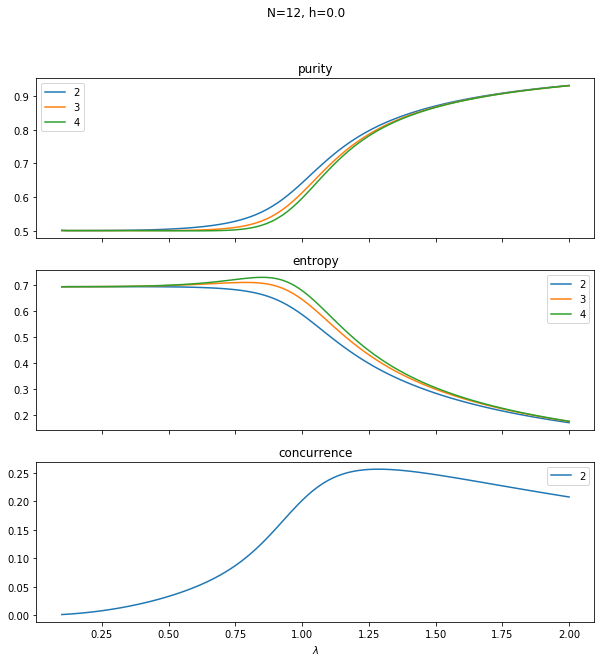

In [11]:
quants, axs = plt.subplots(3,sharex=True,figsize=[10,10])

for L in (2,3,4):

    purs=[]

    for j,l in enumerate(lambdarange):    

        qrho_2=dictionary_open0_h0[l,L]

        eigval,eigstat=qrho_2.eigenstates()

        eigsquared=[x**2 for x in eigval]

        purs.append(sum(eigsquared))

    axs[0].plot(lambdarange,purs,label=L)
    axs[0].set_title("purity")

    axs[0].legend()

    entros=[]

    for j,l in enumerate(lambdarange):    

        qrho_2=dictionary_open0_h0[l,L]

        entr=q.entropy_vn(qrho_2)

        entros.append(entr)

    axs[1].plot(lambdarange,entros,label=L)
    axs[1].legend()
    axs[1].set_title("entropy")
    if L==2:
        concs=[]

        for j,l in enumerate(lambdarange):    

            qrho_2=dictionary_open0_h0[l,2]

            conc=q.concurrence(qrho_2)

            concs.append(conc)

        axs[2].plot(lambdarange,concs,label=2)
        plt.xlabel(r"$\lambda$")
        axs[2].set_title("concurrence")

        axs[2].legend()
        quants.suptitle( 'N={}, h={}'.format(length,h_0))   
quants.savefig("h0_quantities")
plt.show()

In [22]:
length=12
h_0=0.00
lambdarange=np.linspace(0.1,2,100)

In [25]:
dictionary_h0_distant={}

for l in lambdarange:


    Energies,psis=diagonalize(2,length,isingmodel_rev_frac2(l,h_0),True)

    #reshapedpsi0=psis[:,0].reshape(2**int((length-2)/2),2,2,2,-1).transpose(1,3,0,2,4).reshape(4,-1)
    qpsi=q.Qobj(psis[:,0],dims=[[2]*length,[1]*length])
    
    rhomagn0 = qpsi.ptrace([5,7])
    rhomagn1 = qpsi.ptrace([5,8])


    qrhomagn0=q.Qobj(rhomagn0,dims=[[2,2],[2,2]])
    
    qrhomagn1=q.Qobj(rhomagn1,dims=[[2,2],[2,2]])


    dictionary_h0_distant[l]=qrhomagn0,qrhomagn1
        

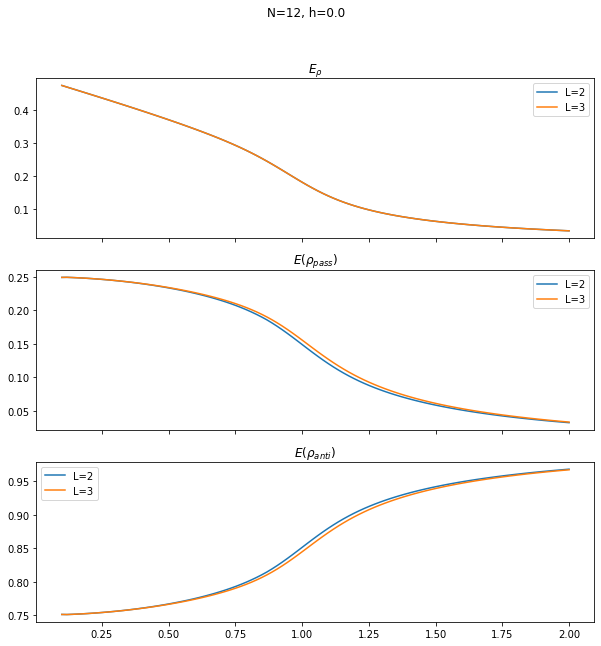

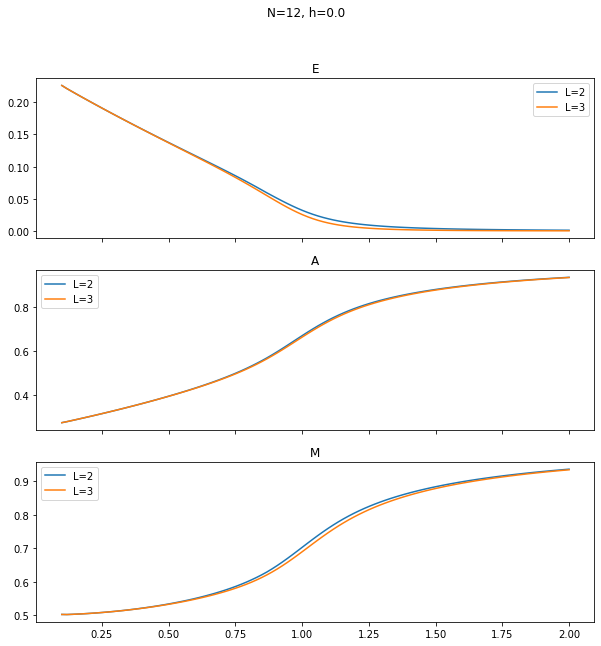

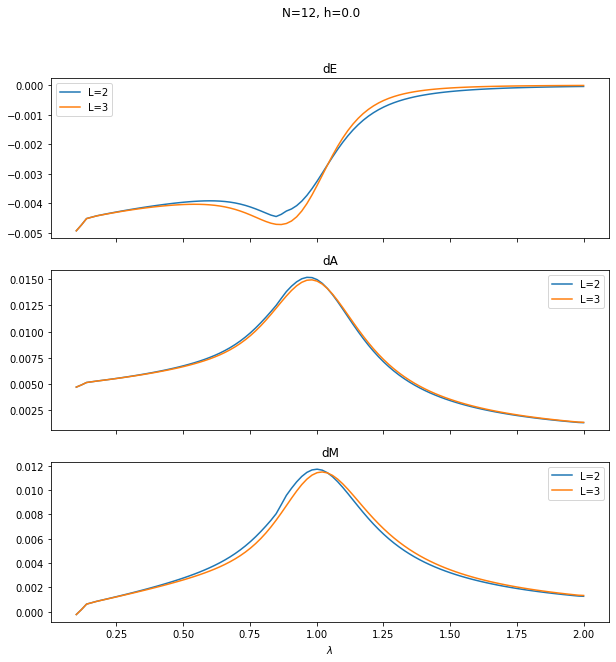

In [26]:
from functions import construct_distant_ham_2sites


prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
fig, axs = plt.subplots(3,sharex=True,figsize=[10,10])
fig2, axs2 = plt.subplots(3,sharex=True,figsize=[10,10])
fig3, axs3 = plt.subplots(3,sharex=True,figsize=[10,10])


for L in (2,3):
    energies_pass=np.zeros_like(lambdarange)
    energies_subs=np.zeros_like(lambdarange)
    energies_antipass=np.zeros_like(lambdarange)

    for j,l in enumerate(lambdarange):    

        qrho2=dictionary_h0_distant[l][L-2]

        eigval,eigstat=qrho2.eigenstates()

        reduced_H_matr=construct_distant_ham_2sites(2,l)

        h_eigval, h_eigvec= reduced_H_matr.eigenstates()

        rho_pass=q.Qobj()
        rho_anti=q.Qobj()

        sortdesc=np.sort(eigval)[::-1]

        for i in range(len(eigval)):    
            rho_pass+=sortdesc[i]*q.ket2dm(h_eigvec[i])

        for i in range(len(eigval)):    
            rho_anti+=eigval[i]*q.ket2dm(h_eigvec[i])

        ener_pass=q.expect(rho_pass,reduced_H_matr)-h_eigval[0]
        ener_subs=q.expect(qrho2,reduced_H_matr)-h_eigval[0]
        ener_anti=q.expect(rho_anti,reduced_H_matr)-h_eigval[0]

        energies_pass[j]=(ener_pass)/(2*abs(h_eigval[0]))
        energies_subs[j]=(ener_subs)/(2*abs(h_eigval[0]))
        energies_antipass[j]=(ener_anti)/(2*abs(h_eigval[0]))


    fig.suptitle( 'N={}, h={}'.format(length,h_0))   

    axs[0].plot(lambdarange,energies_subs,label= "L={}".format(L))
    axs[0].set_title(r"$E_{\rho}$")
    axs[1].plot(lambdarange,energies_pass,label= "L={}".format(L))
    axs[1].set_title(r"$E(\rho_{pass})$")
    axs[2].plot(lambdarange,energies_antipass,label="L={}".format(L))
    axs[2].set_title(r"$E(\rho_{anti})$")

    for k in range(3):
        axs[k].legend()
    plt.xlabel(r"$\lambda$")

    fig.savefig("h0_rhos")
    fig2.suptitle("N={}, h={}".format(length,h_0))   

    axs2[0].plot(lambdarange,(energies_subs-energies_pass),label="L={}".format(L))        
    axs2[0].set_title("E")
    axs2[1].plot(lambdarange,(energies_antipass-energies_subs),label="L={}".format(L))
    axs2[1].set_title("A")    
    axs2[2].plot(lambdarange,(energies_antipass-energies_pass),label="L={}".format(L))
    axs2[2].set_title("M")

    for k in range(3):
        axs2[k].legend()

    fig3.suptitle("N={}, h={}".format(length,h_0)) 

    axs3[0].plot(lambdarange,np.gradient(energies_subs-energies_pass),label= "L={}".format(L))
    axs3[0].set_title(r"dE")
    axs3[1].plot(lambdarange,np.gradient(energies_antipass-energies_subs),label="L={}".format(L))
    axs3[1].set_title(r"dA")
    axs3[2].plot(lambdarange,np.gradient(energies_antipass-energies_pass),label="L={}".format(L))
    axs3[2].set_title("dM")    

    for k in range(3):
        axs3[k].legend()

    plt.xlabel(r"$\lambda$")


plt.show()   